In [17]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score as calculate_f1_score 
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
torch.set_printoptions(edgeitems=2, linewidth=75)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
# Preprocess the data
file_path = r'/home/charlie51135/ml_final/dataset.csv'
dataframe = pd.read_csv(file_path)
# Check for null values
# print(dataframe.isnull().sum()*100/dataframe.shape[0])

# Convert 'Date' column to datetime and extract month and year
dataframe['Date'] = pd.to_datetime(dataframe['Date'])
dataframe['Month'] = dataframe['Date'].dt.month
dataframe['Year'] = dataframe['Date'].dt.year
dataframe = dataframe.drop(columns=['Date'])

# Map 'Year' to a number representing the order
dataframe['Year'] = dataframe['Year'] - dataframe['Year'].min()

# Target variable 'SPX'
y = dataframe.pop('SPX').values

# Set up the one-hot encoder for the 'Month' column and StandardScaler to remaining
continuous_columns = [col for col in dataframe.columns if col != 'Month']

preprocessor = ColumnTransformer(
    transformers=[
        ('month', OneHotEncoder(), ['Month']),
        ('scale', StandardScaler(), continuous_columns)
    ])

# Apply the pipeline to the data
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_data = pipeline.fit_transform(dataframe)

# Convert to tensors
X_tensor = torch.tensor(X_data, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split training and test data
torch.manual_seed(123)
n_samples = X_tensor.shape[0]
n_val = int(n_samples * 0.3)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

# Create tensors
X_train = X_tensor[train_indices].to(device, non_blocking=True)
y_train = y_tensor[train_indices].to(device, non_blocking=True)
X_val = X_tensor[val_indices].to(device, non_blocking=True)
y_val = y_tensor[val_indices].to(device, non_blocking=True)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [23]:
# # NN model class- no dropout or batch normalization
# class Net(nn.Module):
#     def __init__(self, n_chans1, hid_layers, activation_function):
#         super(Net, self).__init__()
#         self.hid_layers = hid_layers

#         # First hidden layer
#         self.layer1 = nn.Linear(71, n_chans1)

#         # Conditional layers
#         if hid_layers > 1:
#             self.layer2 = nn.Linear(n_chans1, n_chans1 * 2)
#         if hid_layers > 2:
#             self.layer3 = nn.Linear(n_chans1 * 2, n_chans1 // 2)

#         # Output layer
#         if hid_layers == 1:
#             self.layer4 = nn.Linear(n_chans1, 2)
#         elif hid_layers == 2:
#             self.layer4 = nn.Linear(n_chans1 * 2, 2)
#         else:  # hid_layers == 3
#             self.layer4 = nn.Linear(n_chans1 // 2, 2)
        
#         self.activation = activation_function

#     # Define forward path
#     def forward(self, x):
#         out = self.activation(self.layer1(x))
#         if self.hid_layers > 1:
#             out = self.activation(self.layer2(out))
#         if self.hid_layers > 2:
#             out = self.activation(self.layer3(out))
#         out = self.layer4(out)
#         return out


# NN model class with dropout and batch normalization
class FCNN(nn.Module):
    def __init__(self, n_chans1, hid_layers, activation_function, dropout_prob):
        super(FCNN, self).__init__()
        self.hid_layers = hid_layers

        # First hidden layer
        self.layer1 = nn.Linear(71, n_chans1)
        self.bn1 = nn.BatchNorm1d(n_chans1)
        self.dropout1 = nn.Dropout(dropout_prob)

        # Conditional layers
        if hid_layers > 1:
            self.layer2 = nn.Linear(n_chans1, n_chans1 * 2)
            self.bn2 = nn.BatchNorm1d(n_chans1 * 2)
            self.dropout2 = nn.Dropout(dropout_prob)
        if hid_layers > 2:
            self.layer3 = nn.Linear(n_chans1 * 2, n_chans1 // 2)
            self.bn3 = nn.BatchNorm1d(n_chans1 // 2)
            self.dropout3 = nn.Dropout(dropout_prob)

        # Output layer
        if hid_layers == 1:
            self.layer4 = nn.Linear(n_chans1, 2)
        elif hid_layers == 2:
            self.layer4 = nn.Linear(n_chans1 * 2, 2)
        else:  # hid_layers == 3
            self.layer4 = nn.Linear(n_chans1 // 2, 2)

        self.activation = activation_function

    # Define forward path
    def forward(self, x):
        out = self.dropout1(self.activation(self.bn1(self.layer1(x))))
        if self.hid_layers > 1:
            out = self.dropout2(self.activation(self.bn2(self.layer2(out))))
        if self.hid_layers > 2:
            out = self.dropout3(self.activation(self.bn3(self.layer3(out))))
        out = self.layer4(out)
        return out

# Validation function to calculate all metrics
def validate(model, train_loader, val_loader):
    model.eval()
    results = {
        "train": {"accuracy": 0, "f1_score": 0, "precision": 0, "recall": 0},
        "val": {"accuracy": 0, "f1_score": 0, "precision": 0, "recall": 0}
    }
    loaders = {"train": train_loader, "val": val_loader}

    for phase in ['train', 'val']:
        all_preds = []
        all_targets = []

        for X, y in loaders[phase]:
            with torch.no_grad():
                outputs = model(X)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(y.cpu().numpy())

        accuracy = accuracy_score(all_targets, all_preds)
        f1 = calculate_f1_score(all_targets, all_preds, average='binary')
        precision = precision_score(all_targets, all_preds, average='binary', zero_division=0)
        recall = recall_score(all_targets, all_preds, average='binary', zero_division=0)
        
        results[phase]["accuracy"] = accuracy
        results[phase]["f1_score"] = f1
        results[phase]["precision"] = precision
        results[phase]["recall"] = recall

    return results

# Training loop function
def training_loop(n_epochs, early_stop, train_updates, optimizer, model, loss_fn, train_loader, val_loader):
    best_score = 0.0
    epochs_without_improvement = 0
    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            train_y_pred = model(X_batch)
            train_loss = loss_fn(train_y_pred, y_batch)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            running_loss += train_loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        results = validate(model, train_loader, val_loader)

        # Optional print results per x epochs
        if epoch % 5 == 0 and train_updates == True:
            print(f"Epoch: {epoch}, Training Loss: {avg_train_loss:.6f}, "
                f"Training Accuracy: {results['train']['accuracy']:.4f}, "
                f"Validation Accuracy: {results['val']['accuracy']:.4f}")
            
        # Early stopping check using accuracy
        if early_stop == True:
            val_score = results['val']['accuracy']
            if val_score > best_score:
                best_score = val_score
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= 50:
                return results
    return results

In [24]:
# Define parameter space
learning_rate_options = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
optimizer_options = [optim.SGD, optim.Adam]
activation_options = [nn.Sigmoid(), nn.ReLU(), nn.Tanh(), nn.LeakyReLU()]
n_chans1_options = [16, 32, 64, 128]
hid_layers_options = [1, 2, 3]
dropout_prob_options = [0.5, 0.6]

resultsList = []

# Exhaustive gird search
for lr in learning_rate_options:
    for optimizer_class in optimizer_options:
        for activation_function in activation_options:
            for n_chans1 in n_chans1_options:
                for hid_layers in hid_layers_options:
                    for dropout_prob in dropout_prob_options:
                        torch.manual_seed(123)

                        model = FCNN(n_chans1, 
                                     hid_layers, 
                                     activation_function, 
                                     dropout_prob
                                     ).to(device, non_blocking=True)
                        
                        optimizer = optimizer_class(model.parameters(), lr=lr)
                        loss_function = nn.CrossEntropyLoss()

                        results = training_loop(
                            n_epochs = 500,
                            early_stop = True,
                            train_updates = False,
                            optimizer = optimizer,
                            model = model,
                            loss_fn = loss_function,
                            train_loader = train_loader,
                            val_loader = val_loader)

                        # Add the results
                        val_results = results['val']
                        val_results['lr'] = lr
                        val_results['optimizer'] = optimizer_class.__name__
                        val_results['activation_function'] = type(activation_function).__name__
                        val_results['loss_function'] = type(loss_function).__name__
                        val_results['n_chans1'] = n_chans1
                        val_results['hid_layer'] = hid_layers
                        val_results['dropout_prob'] = dropout_prob
                        resultsList.append(val_results)

# Sort results by single metric
resultsList = sorted(resultsList, key=lambda x: x['precision'], reverse=True) 
for result in resultsList: 
    print(result)

{'accuracy': 0.4691358024691358, 'f1_score': 0.31746031746031744, 'precision': 0.8333333333333334, 'recall': 0.19607843137254902, 'lr': 1e-05, 'optimizer': 'SGD', 'activation_function': 'ReLU', 'loss_function': 'CrossEntropyLoss', 'n_chans1': 64, 'hid_layer': 3, 'dropout_prob': 0.6}
{'accuracy': 0.48148148148148145, 'f1_score': 0.3636363636363636, 'precision': 0.8, 'recall': 0.23529411764705882, 'lr': 0.0001, 'optimizer': 'SGD', 'activation_function': 'Tanh', 'loss_function': 'CrossEntropyLoss', 'n_chans1': 16, 'hid_layer': 3, 'dropout_prob': 0.6}
{'accuracy': 0.49382716049382713, 'f1_score': 0.4057971014492754, 'precision': 0.7777777777777778, 'recall': 0.27450980392156865, 'lr': 1, 'optimizer': 'Adam', 'activation_function': 'Sigmoid', 'loss_function': 'CrossEntropyLoss', 'n_chans1': 64, 'hid_layer': 1, 'dropout_prob': 0.6}
{'accuracy': 0.691358024691358, 'f1_score': 0.7474747474747475, 'precision': 0.7708333333333334, 'recall': 0.7254901960784313, 'lr': 0.0001, 'optimizer': 'SGD', '

In [25]:
# Sort results by single metric
resultsList = sorted(resultsList, key=lambda x: x['accuracy'], reverse=True) 
for result in resultsList: 
    print(result)

{'accuracy': 0.7037037037037037, 'f1_score': 0.7894736842105262, 'precision': 0.7142857142857143, 'recall': 0.8823529411764706, 'lr': 0.0001, 'optimizer': 'Adam', 'activation_function': 'Tanh', 'loss_function': 'CrossEntropyLoss', 'n_chans1': 16, 'hid_layer': 2, 'dropout_prob': 0.5}
{'accuracy': 0.691358024691358, 'f1_score': 0.7474747474747475, 'precision': 0.7708333333333334, 'recall': 0.7254901960784313, 'lr': 0.0001, 'optimizer': 'SGD', 'activation_function': 'Tanh', 'loss_function': 'CrossEntropyLoss', 'n_chans1': 16, 'hid_layer': 2, 'dropout_prob': 0.6}
{'accuracy': 0.691358024691358, 'f1_score': 0.7474747474747475, 'precision': 0.7708333333333334, 'recall': 0.7254901960784313, 'lr': 1e-05, 'optimizer': 'Adam', 'activation_function': 'Tanh', 'loss_function': 'CrossEntropyLoss', 'n_chans1': 16, 'hid_layer': 2, 'dropout_prob': 0.6}
{'accuracy': 0.691358024691358, 'f1_score': 0.7747747747747747, 'precision': 0.7166666666666667, 'recall': 0.8431372549019608, 'lr': 0.001, 'optimizer':

Epoch: 5, Training Loss: 0.776551, Training Accuracy: 0.4474, Validation Accuracy: 0.6543
Epoch: 10, Training Loss: 0.779286, Training Accuracy: 0.4526, Validation Accuracy: 0.6790
Epoch: 15, Training Loss: 0.744558, Training Accuracy: 0.4474, Validation Accuracy: 0.6914
Epoch: 20, Training Loss: 0.763857, Training Accuracy: 0.4421, Validation Accuracy: 0.6790
Epoch: 25, Training Loss: 0.771866, Training Accuracy: 0.4421, Validation Accuracy: 0.6914
Epoch: 30, Training Loss: 0.741980, Training Accuracy: 0.4474, Validation Accuracy: 0.6790
Epoch: 35, Training Loss: 0.726353, Training Accuracy: 0.4421, Validation Accuracy: 0.6914
Epoch: 40, Training Loss: 0.744526, Training Accuracy: 0.4526, Validation Accuracy: 0.6914
Epoch: 45, Training Loss: 0.790304, Training Accuracy: 0.4421, Validation Accuracy: 0.6914
Epoch: 50, Training Loss: 0.752356, Training Accuracy: 0.4474, Validation Accuracy: 0.6790

Learning Rate = 1e-05
Confusion matrix:
 [[19 11]
 [14 37]]
Training Results - Accuracy: 0

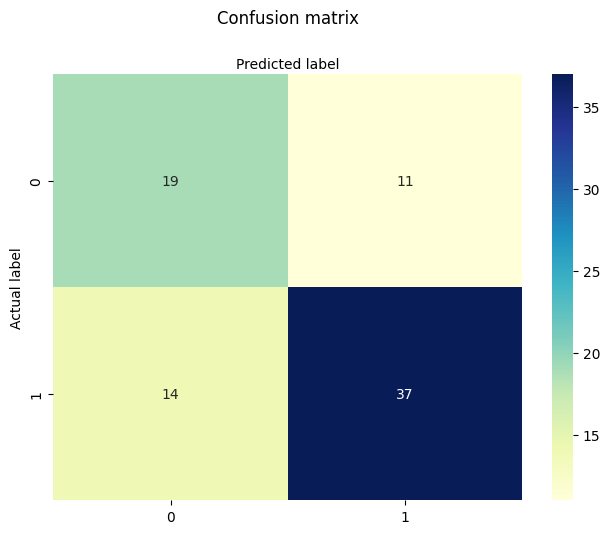

In [26]:
# Define parameters
learning_rates = [.00001]
optimizer_class = optim.Adam
activation_function = nn.Tanh()
loss_function = nn.CrossEntropyLoss()
n_chans1 = 16
hid_layer = 2
dropout_prob = 0.6

for lr in learning_rates:
    torch.manual_seed(123)

    model = FCNN(n_chans1, 
                 hid_layer, 
                 activation_function, 
                 dropout_prob
                 ).to(device, non_blocking=True)
    
    optimizer = optimizer_class(model.parameters(), lr=lr)

    results = training_loop(
        n_epochs = 1000,
        early_stop = True,
        train_updates = True,
        optimizer = optimizer,
        model = model,
        loss_fn = loss_function,
        train_loader = train_loader,
        val_loader = val_loader)
    
    # Get confusion matrix
    with torch.no_grad():
        val_y_pred = model(X_val)
    # Predicted class is the higher probability
    predicted_classes = torch.max(val_y_pred, 1)[1]
    y_val_np = y_val.cpu().numpy()
    cnf_matrix = confusion_matrix(y_val_np, predicted_classes.cpu().numpy())

    # Print results
    print("\nLearning Rate =", lr)
    print("Confusion matrix:\n", cnf_matrix)

    print(f"Training Results - Accuracy: {results['train']['accuracy']:.4f}, "
        f"Precision: {results['train']['precision']:.4f}, "
        f"Recall: {results['train']['recall']:.4f}, "
        f"F1 Score: {results['train']['f1_score']:.4f}")

    print(f"Validation Results - Accuracy: {results['val']['accuracy']:.4f}, "
        f"Precision: {results['val']['precision']:.4f}, "
        f"Recall: {results['val']['recall']:.4f}, "
        f"F1 Score: {results['val']['f1_score']:.4f}")

    # Confusion matrix using heatmap
    class_names=[0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # Create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')